#GAN으로 만드는 새로운 패션

이번 프로젝트는 GAN을 사용한 새로운 패션만들기입니다.

사실 말이 패션이지 패션은 아닌거 같습니다.

데이터셋으로는 CIFAR10 데이터를 사용합니다.

처음 GAN을 보았을때는 정말 흥미롭게 느껴졌습니다.

이미지 또한, 상당히 괜찮게 나올줄 알았지만, 그건 아니였던거 같습니다. ㅠㅠ




목차

데이터 살펴보기

- 사전준비
- 데이터 정보 확인
- 데이터 정규화

모델 정의

- 배치 사이즈 지정
- 생성자 구현
- 노이즈 이미지 생성
- 판별자 구현하기
- 손실 함수와 최적화 함수 구현

모델 결과 확인

- train_step 함수 구현
- 에포크마다 생성된 이미지를 저장하는 함수
- 학습결과 시각화 함수
- 모델 저장 함수
- 모델 학습 함수
- 이미지 생성과정 GIF화
- 정확도 GIF화
- GIF 결과 확인

모델 더 좋게 좋게

- 첫번째 시도
- 첫번째 모델 GIF 결과 확인
- 두번째 모델 만들기
- 두번째 모델 GIF 결과 확인
- 세번째 모델 만들기
- 세번째 모델 GIF 결과 확인
- 최종 결과 확인

마무리


#데이터 살펴보기

##사전준비

필요한 라이브러리 설치와 구글 드라이브 및 라이브러리를 임포트 해줍니다.

In [ ]:
!pip install imageio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt

---

##데이터 정보 확인

CIFAR10 이라는 데이터는 텐서플로우 datasets에 저장되어있습니다.



```
cifar10 = tf.keras.datasets.cifar10
```
위에 코드를 입력하여 cifar10에 해당 데이터를 변수로 받아줍니다.


In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

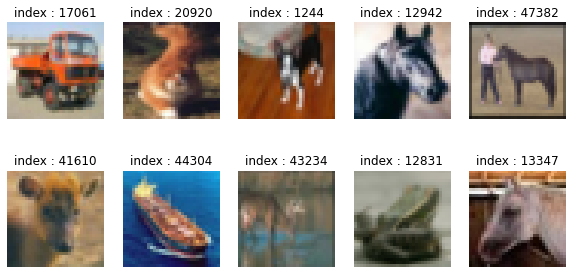

In [ ]:
plt.figure(figsize = (10, 5))
for i in range(10):
  plt.subplot(2, 5, i+1)
  rnd = np.random.randint(len(train_x))
  plt.imshow(train_x[rnd])
  plt.title('index : {}'.format(rnd))
  plt.axis('off')
plt.show()

---

##데이터 정규화

불러온 데이터는 0~255에 값을 가지고 있습니다.

정규화를 시키지 않으면 연산 속도도 느려지고 값 편차에 따라서 모델 성능이 저하될수 있습니다.

따라서 데이터 값을 -1.0 ~ 1.0 사이로 정규화 해주고 진행하겠습니다.

In [ ]:
train_x.shape

(50000, 32, 32, 3)

In [ ]:
print(train_x.max(), train_x.min())

255 0


In [ ]:
train_x = (train_x - 127.5) / 127.5
print(train_x.max(), train_x.min())

1.0 -1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

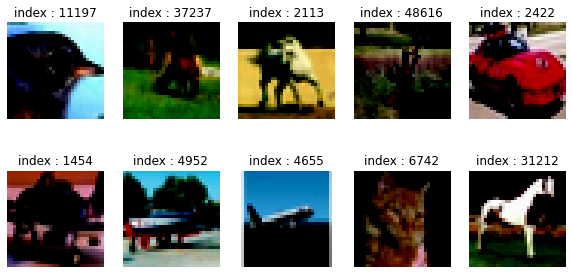

In [ ]:
plt.figure(figsize = (10, 5))
for i in range(10):
  plt.subplot(2, 5, i+1)
  rnd = np.random.randint(len(train_x))
  plt.imshow(train_x[rnd])
  plt.title('index : {}'.format(rnd))
  plt.axis('off')
plt.show()

---

#모델 정의

##배치 사이즈 지정

버퍼 사이즈와 배치 사이즈를 지정하여 한번에 학습시킬 이미지 양을 정해줍니다.

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

---

##생성자 구현

노이즈 벡터를 입력으로 받아 새로운 이미지를 만들어 줍니다.

처음 모델은 실습에서 사용한 파라미터값을 그대로 사용하겠습니다.

In [ ]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

---

##노이즈 이미지 생성

입력으로 사용할 노이즈 이미지를 생성해줍니다.

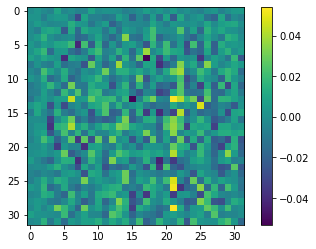

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

---

##판별자 구현하기

가짜와 진짜 이미지를 입력받게 되면 각 이미지 별로 '진짜라고 판단하는 정도'를 알려줘야합니다.

그걸 판별자라고 합니다.

판별자를 구현해보겠습니다.

In [ ]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

---

##손실 함수와 최적화 함수 구현

- 생성자 : 판별자가 Fake Image에 대해 판별한 값, 즉 D(fake_image) 값이 1에 가까워지는 것
- 판별자 : Real Image 판별값, 즉 D(real_image)는 1에, Fake Image 판별값, 즉 D(fake_image)는 0에 가까워지는 것

이러한 기준을 가지고 생성자 판별자 각각에 대한 손실함수를 설계하겠습니다.

손실함수에 사용할 교차 엔트로피 함수는 tf.keras.losses 라이브러리 안에 있습니다.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#fake_output : 생성자가 생성한 Fake Image를 구분자에 입력시켜서 판별된 값, 즉 D(fake_image)
#real_output : 기존에 있던 Real Image를 구분자에 입력시켜서 판별된 값, 즉 D(real_image)
#generator_loss는 fake_output가 1에 가까워지기를 바라므로, 다음과 같이 tf.ones_like와의 교차 엔트로피값을 계산하면 됩니다.
#즉, cross_entropy(tf.ones_like(fake_output), fake_output) 
#값은 fake_output이 (Real Image를 의미하는) 1에 가까울수록 작은 값을 가집니다.

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지는 것이 이상적입니다.

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

---

#모델 결과 확인

##train_step 함수 구현

In [ ]:
@tf.function
def train_step(images):  #(1)  입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 
                                                        #images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5)  discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 
        # generated_images를 각각 입력받은 후 real_output, fake_output 출력
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

---

##에포크마다 생성된 이미지를 저장하는 함수

In [ ]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(predictions[i] * 127.5 + 127.5).astype('uint8'))
        plt.axis('off')
   
    plt.savefig('/content/drive/MyDrive/pic/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))

    plt.show()

---

##학습결과 시각화 함수

In [ ]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/content/drive/MyDrive/pic/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

---

##모델 저장 함수

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/pic/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---

##모델 학습 함수

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 300

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

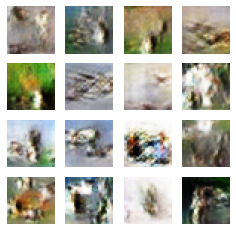

Time for training : 3042 sec


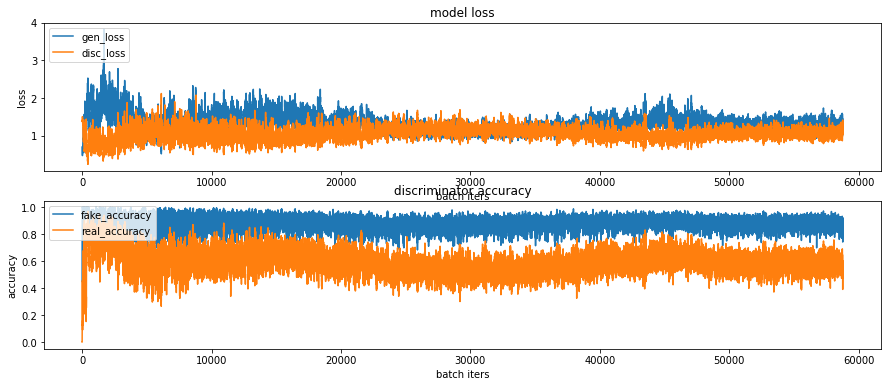

CPU times: user 51min 2s, sys: 52.7 s, total: 51min 55s
Wall time: 50min 45s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

---

##이미지 생성과정 GIF화

In [ ]:
anim_file = '/content/drive/MyDrive/pic/dcgan_newimage/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/pic/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

---

##정확도 GIF화

In [ ]:
anim_file = '/content/drive/MyDrive/pic/dcgan_newimage/l&a.gif'

plt.savefig('/content/drive/MyDrive/pic/training_history/train_history_{:04d}.png')
    
    
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/pic/training_history/train_history_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<Figure size 1080x432 with 0 Axes>

---

##GIF 결과 확인

코랩에서 GIF이미지를 업로드 할라고 하면 튕기는 문제로 링크로 첨부하였습니다.

[이미지 변화](https://drive.google.com/file/d/1MzP0_an3QrWkWRnH1Np7rl5NyWeoAo_w/view?usp=sharing)

[accuracy 변화](https://drive.google.com/file/d/1FKALkxHGeCWkcoRWXMex1JBzmWPc86Gq/view?usp=sharing)

----

#모델 더 좋게 좋게

##첫번째 시도

첫번째 모델 시도에서는 레이어를 좀 더 쌓아서 진행해 봤습니다.

In [ ]:
def make_generator_model_1():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator_1 = make_generator_model_1()
generator_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_3 (Batc  (None, 16384)            65536     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 256)        1638400   
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 8, 8, 256)       

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator_1(noise, training=False)

In [ ]:
def make_discriminator_model_1():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator_1 = make_discriminator_model_1()
discriminator_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 16, 16, 256)       19456     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         819328    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 64)         

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

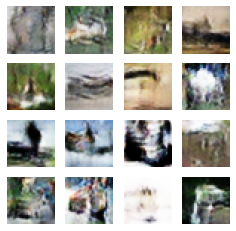

Time for training : 1984 sec


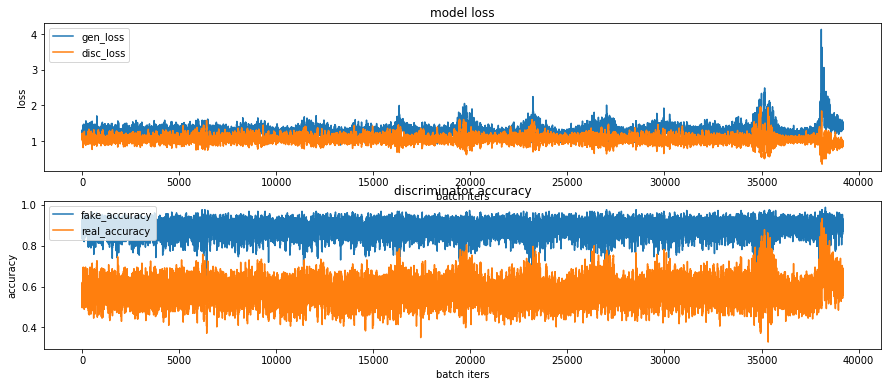

CPU times: user 33min 30s, sys: 26.7 s, total: 33min 57s
Wall time: 33min 6s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/pic/dcgan_newimage/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/pic/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
anim_file = '/content/drive/MyDrive/pic/dcgan_newimage/l&a.gif'

plt.savefig('/content/drive/MyDrive/pic/training_history/train_history_{:04d}.png')
    
    
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/pic/training_history/train_history_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<Figure size 1080x432 with 0 Axes>

---

##첫번째 모델 GIF 결과 확인

[이미지 변화](https://drive.google.com/file/d/1WID52vSQxB0jOKS3DUDJNxobgLIdKeQo/view?usp=sharing)

[accuracy 변화](https://drive.google.com/file/d/1uhMgRFnXTyAfaUCU_qsGmZS1a4F2D6L1/view?usp=sharing)

---

##두번째 모델 만들기

BatchNormalization과 LeakyReLU안에 하이퍼 파라미터 값을 넣어봤습니다.

In [ ]:
def make_generator_model_2():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*128, activation='relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

In [ ]:
generator_2 = make_generator_model_2()
generator_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_9 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 8, 8, 128)        409728    
 ranspose)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 8, 8, 128)       

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator_2(noise, training=False)

In [ ]:
def make_discriminator_model_2():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.25))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator_2 = make_discriminator_model_2()
discriminator_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 16, 16, 256)       19456     
                                                                 
 batch_normalization_15 (Bat  (None, 16, 16, 256)      1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 128)         819328    
                                                                 
 batch_normalization_16 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                     

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 32

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.7)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.7)

save_every = 5
EPOCHS = 200

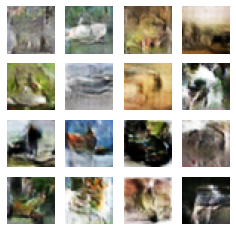

Time for training : 1962 sec


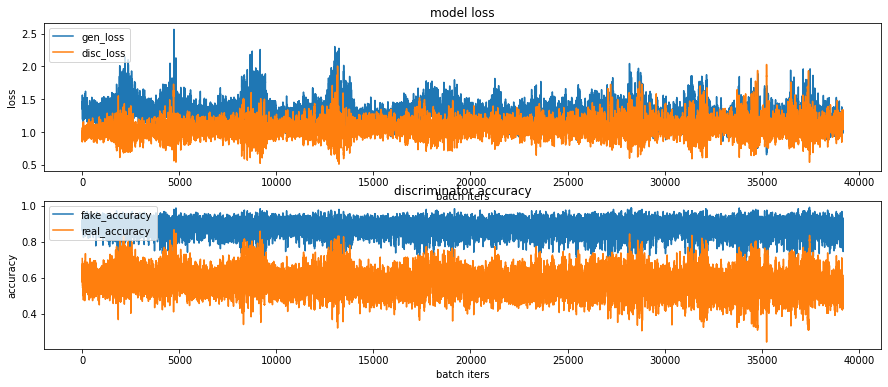

CPU times: user 33min 10s, sys: 27.5 s, total: 33min 37s
Wall time: 32min 44s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/pic/dcgan_newimage/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/pic/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
anim_file = '/content/drive/MyDrive/pic/dcgan_newimage/l&a.gif'

plt.savefig('/content/drive/MyDrive/pic/training_history/train_history_{:04d}.png')
    
    
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/pic/training_history/train_history_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<Figure size 1080x432 with 0 Axes>

---

##두번째 모델 GIF 결과 확인

[이미지 변화](https://drive.google.com/file/d/1J1iM-p74l6N0OeiipV_fpSTWEE2GT3PQ/view?usp=sharing)

[accuracy 변화](https://drive.google.com/file/d/197a7OOZGJp4e_IR2PyRQftxqPMo_ZCmd/view?usp=sharing)

---

##세번째 모델 만들기

하이퍼 파라미터 값만 조금씩 수정해봤습니다.

In [ ]:
def make_generator_model_3():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*128, activation='relu', input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2D(3, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='tanh'))

    return model

In [ ]:
generator_3 = make_generator_model_3()
generator_3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_19 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 8, 8, 128)        409728    
 ranspose)                                                       
                                                                 
 batch_normalization_20 (Bat  (None, 8, 8, 128)       

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator_3(noise, training=False)

In [ ]:
def make_discriminator_model_3():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.LeakyReLU(alpha=0.1))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator_3 = make_discriminator_model_3()
discriminator_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 16, 16, 256)       19456     
                                                                 
 batch_normalization_24 (Bat  (None, 16, 16, 256)      1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 16, 16, 256)       0         
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 256)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 8, 8, 128)         819328    
                                                                 
 batch_normalization_25 (Bat  (None, 8, 8, 128)        512       
 chNormalization)                                     

In [ ]:
BUFFER_SIZE = 50000
BATCH_SIZE = 16

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.6)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01, beta_1 = 0.6)

save_every = 5
EPOCHS = 200

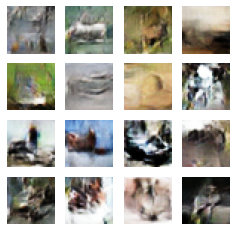

Time for training : 1949 sec


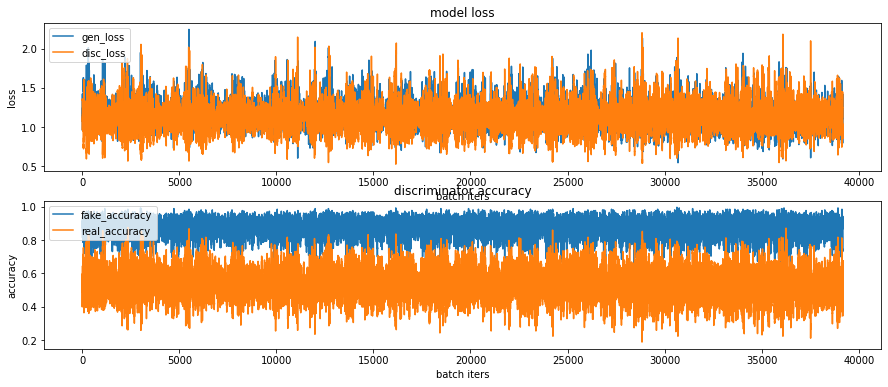

CPU times: user 33min 3s, sys: 28.6 s, total: 33min 32s
Wall time: 32min 31s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = '/content/drive/MyDrive/pic/dcgan_newimage/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/pic/generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
anim_file = '/content/drive/MyDrive/pic/dcgan_newimage/l&a.gif'

plt.savefig('/content/drive/MyDrive/pic/training_history/train_history_{:04d}.png')
    
    
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('/content/drive/MyDrive/pic/training_history/train_history_*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<Figure size 1080x432 with 0 Axes>

---

##세번째 모델 GIF 결과 확인

[이미지 변화](https://drive.google.com/file/d/1PAdDrKZaUqNYgyA_Ki7qFPHVfUuKBwEU/view?usp=sharing)

[accuracy 변화](https://drive.google.com/file/d/1OwIl9KHheMp-dBQRArVJkJAGcPBSQiWN/view?usp=sharing)

---

##최종 결과확인

마지막 모델에서 나온 이미지가 가장 괜찮은거 같습니다.

시각화하여 보도록 하겠습니다.

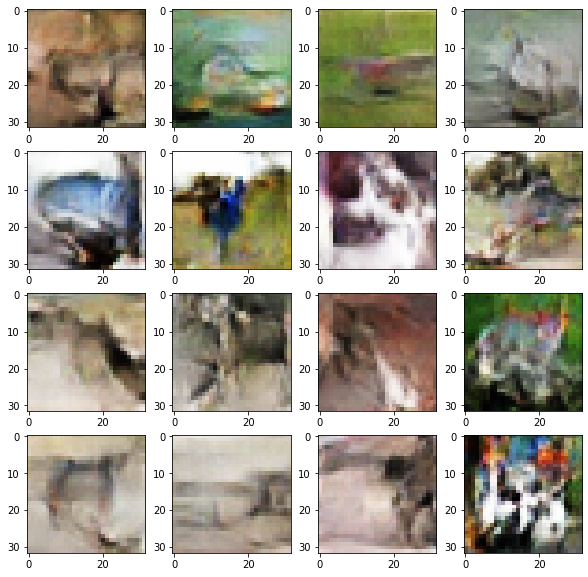

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/pic/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([16, 100])
generated_image = generator(noise, training=False)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    np_generated = generated_image[i].numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated)
plt.show() 

---

#마무리

**실습 이미지는 흑백이미지로 채널수가 1**이었습니다.

하지만 **프로젝트에 이미지는 RGB이미지로 3채널**이었습니다.

처음에는 이 부분을 미쳐확인하지 못해 몇번이고 오류가 발생했었습니다.

결국에는 뒤늦게 확인하고 **input_shape값과 레이어안에 인자값도 바꿔 오류를 해결**했습니다.

(레이어 안에 인자값도 바꿔야하는걸 이제야 알게되었습니다;;)

그 다음으로는 **모델을 3가지나 추가로 만들줄은 몰랐습니다**...

학습을 하면 할수록 이미지는 점점 괜찮아진거 같습니다.

**루브릭 기준에서 gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가**

**추세적으로 0.5를 향해 하향하고 있음을 확인하였다. 라는 항목**이 있습니다.

**모델 결과 GIF라는 셀에 모델 하나하나 GIF 결과 링크를 걸어**두었습니다.

확인하시기바랍니다.

추가적인 학습 결과 개선 방법

1. 배치사이즈가 적을수록 성능이 높음 - **두번째, 세번째 모델**
2. Model 파라미터가 적을수록 성능이 좋음 - **두번째, 세번째 모델**
3. BatchNormalization과 LeakyReLU안에 적절한 인자값 선택으로 성능이 향상될 수 있음 - **두번째, 세번째 모델**
4. learning_rate나 Dropout값을 조금만 고치더라고 성능이 확 변함 - **세번째 모델**

흥미로운 점

1. 하이퍼 파라미터를 살짝만 조절 하더라도 값이 확 바뀜
2. 모델을 새로 만들어서 돌릴수록 이미지가 발전하는것이 흥미로웠음

어려웠던 점

1. 코랩에서 GIF 업로드가 안됨(4번 튕겼음 젠장...)
2. 모델 자체가 매우 무거움
3. 무슨 이미지를 제작한건지 모르겠음(판타지 속 이미지 같음)

아쉬운 점

1. GIF 이미지를 직접 못넣고 링크로 넣은점(꼭 확인하세요!!!!)
2. GAN에 대한 이해도가 부족하여 더 좋은 모델을 만들지 못한점 